In [ ]:

import os
import numpy as np
import pandas as pd
import cv2
from glob import glob

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

def build_model(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = MobileNetV2(input_tensor=inputs, include_top=False, weights="imagenet")
    backbone.trainable = True
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, x)
    return model

def read_image(path, size):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (size, size))
    image = image / 255.0
    image = image.astype(np.float32)
    return image

def parse_data(x, y):
    x = x.decode()

    num_class = 120
    size = 224

    image = read_image(x, size)
    label = [0] * num_class
    label[y] = 1
    label = np.array(label)
    label = label.astype(np.int32)

    return image, label

def tf_parse(x, y):
    x, y = tf.numpy_function(parse_data, [x, y], [tf.float32, tf.int32])
    x.set_shape((224, 224, 3))
    y.set_shape((120))
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

if __name__ == "__main__":
    path = "Dog Breed Identification/"
    train_path = os.path.join(path, "train/*")
    test_path = os.path.join(path, "test/*")
    labels_path = os.path.join(path, "labels.csv")

    labels_df = pd.read_csv(labels_path)
    breed = labels_df["breed"].unique()
    print("Number of Breed: ", len(breed))

    breed2id = {name: i for i, name in enumerate(breed)}
    print(train_path)
    ids = glob(train_path)
    labels = []

    for image_id in ids:
        image_id = image_id.split("/")[-1].split(".")[0]
        breed_name = list(labels_df[labels_df.id == image_id]["breed"])[0]
        breed_idx = breed2id[breed_name]
        labels.append(breed_idx)

    ids = ids[:1000]
    labels = labels[:1000]

    ## Spliting the dataset
    train_x, valid_x = train_test_split(ids, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(labels, test_size=0.2, random_state=42)

    ## Parameters
    size = 224
    num_classes = 120
    lr = 1e-4
    batch = 16
    epochs = 10

    ## Model
    model = build_model(size, num_classes)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["acc"])
    # model.summary()

    ## Dataset
    train_dataset = tf_dataset(train_x, train_y, batch=batch)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

    ## Training
    callbacks = [
        ModelCheckpoint("model.h5", verbose=1, save_best_only=True),
        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
    ]
    train_steps = (len(train_x)//batch) + 1
    valid_steps = (len(valid_x)//batch) + 1
    model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=callbacks)


Number of Breed:  120
Dog Breed Identification/train/*


9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 4.7129 - acc: 0.0478
Epoch 1: val_loss improved from inf to 4.43324, saving model to model.h5
51/51 [==============================] - 164s 3s/step - loss: 4.7129 - acc: 0.0478 - val_loss: 4.4332 - val_acc: 0.1000 - lr: 1.0000e-04
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 2.9217 - acc: 0.5600
Epoch 2: val_loss improved from 4.43324 to 3.83591, saving model to model.h5
51/51 [==============================] - 157s 3s/step - loss: 2.9217 - acc: 0.5600 - val_loss: 3.8359 - val_acc: 0.1700 - lr: 1.0000e-04
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 1.4459 - acc: 0.9056
Epoch 3: val_loss improved from 3.83591 to 3.29673, saving model to model.h5
51/51 [==============================] - 156s 3s/step - loss: 1.4459 - acc: 0.9056 - val_loss: 3.2967 - val_acc: 0.2400 - lr: 1.0000e-04
Epoch 4/10
51/51 [==============

Populating the interactive namespace from numpy and matplotlib
Number of Breed:  120


0it [00:00, ?it/s]

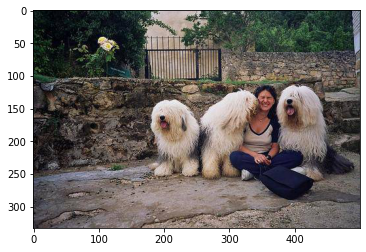

1it [00:00,  1.13it/s]

great_pyrenees


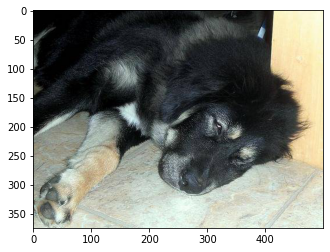

2it [00:01,  1.95it/s]

leonberg


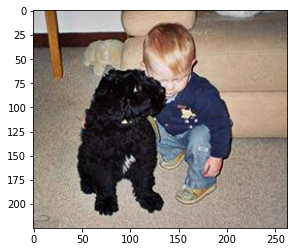

3it [00:01,  2.59it/s]

bouvier_des_flandres


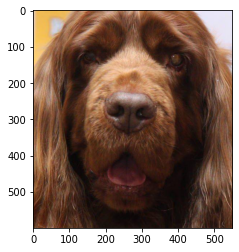

4it [00:01,  3.02it/s]

sussex_spaniel


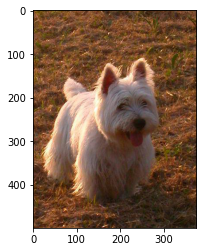

5it [00:01,  3.22it/s]

west_highland_white_terrier


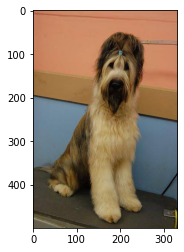

6it [00:02,  3.37it/s]

shih-tzu


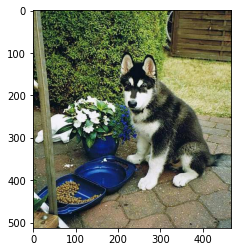

7it [00:02,  3.56it/s]

malamute


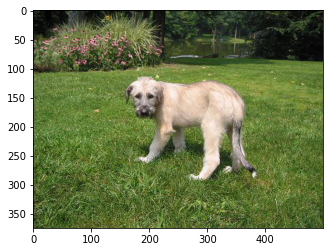

8it [00:02,  3.66it/s]

irish_wolfhound


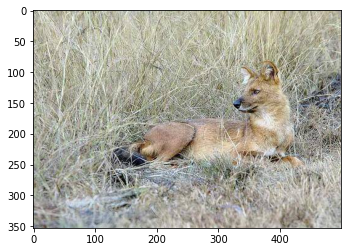

9it [00:02,  3.74it/s]

dhole


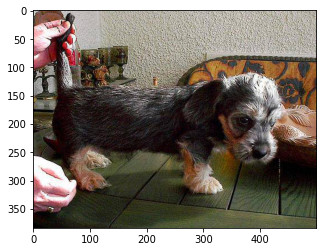

10it [00:03,  3.68it/s]

lhasa


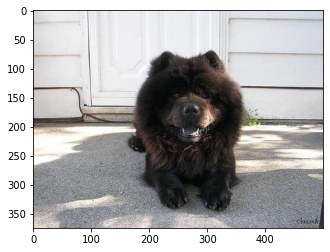

11it [00:03,  3.73it/s]

chow


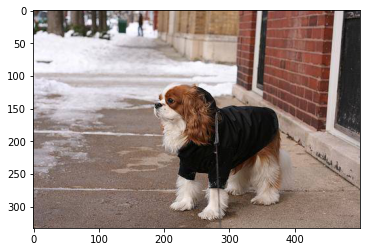

12it [00:03,  3.76it/s]

blenheim_spaniel


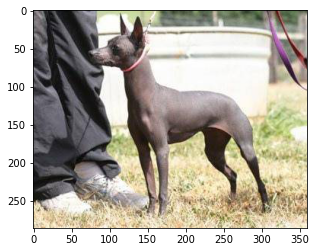

13it [00:03,  3.74it/s]

mexican_hairless


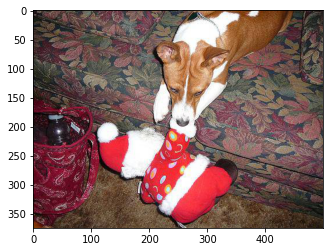

14it [00:04,  3.61it/s]

basenji


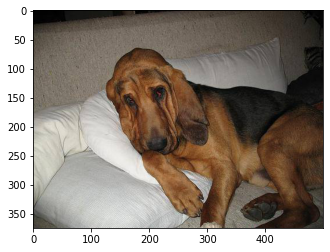

15it [00:04,  3.67it/s]

bloodhound


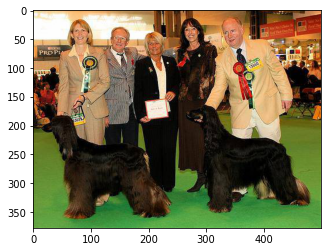

16it [00:04,  3.68it/s]

afghan_hound


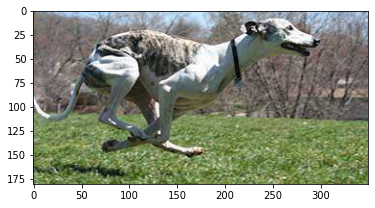

17it [00:05,  3.72it/s]

english_foxhound


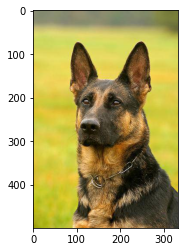

18it [00:05,  3.76it/s]

german_shepherd


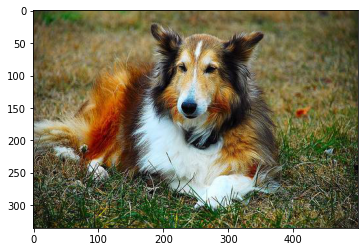

19it [00:05,  3.68it/s]

shetland_sheepdog


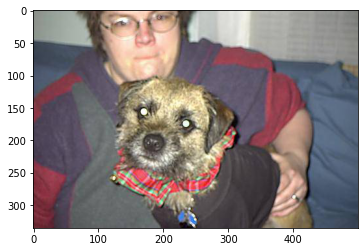

20it [00:05,  3.63it/s]

dandie_dinmont


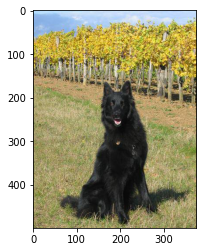

21it [00:06,  3.77it/s]

groenendael


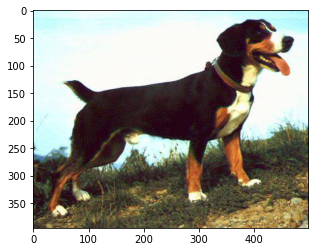

22it [00:06,  3.63it/s]

entlebucher


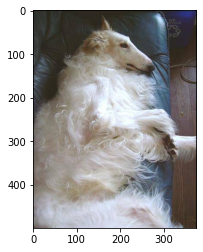

23it [00:06,  3.70it/s]

great_pyrenees


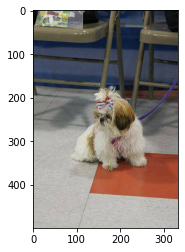

24it [00:06,  3.95it/s]

pekinese


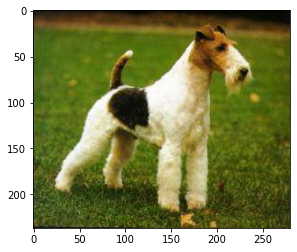

25it [00:07,  3.93it/s]

kerry_blue_terrier


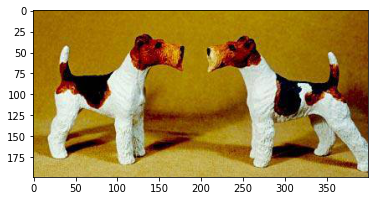

26it [00:07,  3.82it/s]

standard_poodle


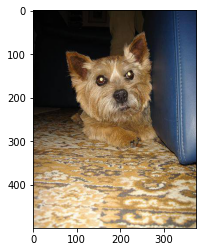

27it [00:07,  3.86it/s]

norwich_terrier


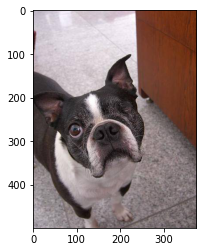

28it [00:08,  2.88it/s]

boston_bull


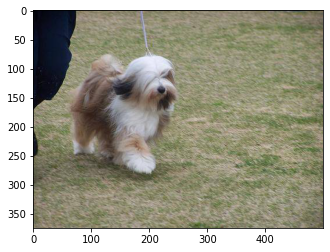

29it [00:08,  3.01it/s]

old_english_sheepdog


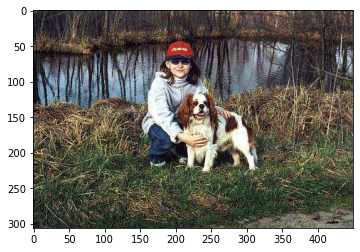

30it [00:08,  3.38it/s]

siberian_husky


In [ ]:

import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

def read_image(path, size):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (size, size))
    image = image / 255.0
    image = image.astype(np.float32)
    return image

if __name__ == "__main__":
    path = "Dog Breed Identification/"
    save_path = "Dog Breed Identification/save"
    train_path = os.path.join(path, "train/*")
    test_path = os.path.join(path, "test/*")
    labels_path = os.path.join(path, "labels.csv")

    labels_df = pd.read_csv(labels_path)
    breed = labels_df["breed"].unique()
    print("Number of Breed: ", len(breed))

    breed2id = {name: i for i, name in enumerate(breed)}
    id2breed = {i: name for i, name in enumerate(breed)}

    ids = glob(train_path)
    labels = []

    for image_id in ids:
        image_id = image_id.split("/")[-1].split(".")[0]
        breed_name = list(labels_df[labels_df.id == image_id]["breed"])[0]
        breed_idx = breed2id[breed_name]
        labels.append(breed_idx)

    ids = ids[:1000]
    labels = labels[:1000]

    ## Spliting the dataset
    train_x, valid_x = train_test_split(ids, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(labels, test_size=0.2, random_state=42)

    ## Model
    model = tf.keras.models.load_model("model.h5")

    for i, path in tqdm(enumerate(valid_x[:30])):
        image = read_image(path, 224)
        image = np.expand_dims(image, axis=0)
        pred = model.predict(image)[0]
        label_idx = np.argmax(pred)
        breed_name = id2breed[label_idx]

        ori_breed = id2breed[valid_y[i]]
        ori_image = cv2.imread(path, cv2.IMREAD_COLOR)

        ori_image = cv2.putText(ori_image, breed_name, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        ori_image = cv2.putText(ori_image, ori_breed, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
        cv2.imwrite(f"save/valid_{i}.png", ori_image)
        img = mpimg.imread(path)
        imgplot = plt.imshow(img)
        plt.show()
        print(breed_name)

